In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

In [2]:
from pandarallel import pandarallel
pandarallel.initialize()
import matplotlib.pyplot as plt
from sklearn.metrics import auc

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
try:
    import AD_result_fetcher
except:
    from . import AD_result_fetcher

In [4]:
set_marked_positive = set()
set_marked_negative = set()
set_seen_records = set()

In [5]:
# =======================
# Baseline 1 
# =======================
DIR = 'us_import1'
PERCENTILE_THRESHOLD = 100
PERCENTILE_THRESHOLD = 100 - 5
REVEAL_STEP = 5
ID_COL = 'PanjivaRecordID'
attribute_SHIPPER = 'ShipperPanjivaID'
attribute_CONSIGNEE = 'ConsigneePanjivaID'
company_attributes = ['ConsigneePanjivaID','ShipperPanjivaID']
UPDATE_scoreUB_percentile =  25 
UPDATE_scoreUB = 0.5



In [6]:
def modify_score_v1(orig_score, num_matches):
    max_matches = 2
    new_score = orig_score * (1 +  (num_matches/max_matches)/2)
    return new_score

In [7]:
labelled_results = AD_result_fetcher.read_in_AD_result(DIR)

score_threshold = np.percentile(labelled_results['score'],PERCENTILE_THRESHOLD)
print(score_threshold)

# The lowest score till which a new score should be calculated
UPDATE_scoreUB = np.percentile(labelled_results['score'],100-UPDATE_scoreUB_percentile)
UPDATE_scoreUB

print('Number of positive anomalies : ', len(labelled_results.loc[labelled_results['label']==1]))
score_threshold = np.percentile(labelled_results['score'],PERCENTILE_THRESHOLD)

22648 22648
0.5650949312585849
Number of positive anomalies :  458


In [8]:
working_df = labelled_results.copy()
working_df['dynamic_score'] = labelled_results['score']
max_iter=len(working_df.loc[working_df['score']>=score_threshold])//REVEAL_STEP

# ------------------
# Type conversion : to ensure no bugs
# ------------------

working_df['PanjivaRecordID'] = working_df['PanjivaRecordID'].astype(int)
working_df['ConsigneePanjivaID'] = working_df['ConsigneePanjivaID'].astype(int)
working_df['ShipperPanjivaID'] = working_df['ShipperPanjivaID'].astype(int)



In [9]:
def process_v1(new_df):
    global set_marked_negative
    global set_marked_positive
    global company_attributes
    global attribute_CONSIGNEE 
    global attribute_SHIPPER
    global UPDATE_scoreUB
    
    def update_row(row):
        count = 0 
        row_dict = row.to_dict()
        if int(row_dict[attribute_SHIPPER]) in set_marked_positive or int(row_dict[attribute_CONSIGNEE]) in set_marked_positive : 
            count = 1
        elif int(row_dict[attribute_SHIPPER]) in set_marked_positive and int(row_dict[attribute_CONSIGNEE]) in set_marked_positive : 
            count = 2
        else: 
            count = 0
            
        new_score = modify_score_v1(
            row_dict['score'],
            count
        )  
        return new_score
    # -----------------------
    # split the dataframe into 2 parts : by score :: UPDATE_scoreUB
    # ------------------------
    
    lower_half = new_df.loc[new_df['score']<=UPDATE_scoreUB]
    lower_half.loc[:,'dynamic_score'] = lower_half['score'].values
    upper_half = new_df.loc[new_df['score']>UPDATE_scoreUB]
    upper_half['dynamic_score'] = upper_half.parallel_apply(update_row,axis=1) 
    new_df = upper_half.append(lower_half,ignore_index=True)
    return new_df

In [10]:
def process_v2(new_df):
    global set_marked_negative
    global set_marked_positive
    global company_attributes
    global attribute_CONSIGNEE 
    global attribute_SHIPPER
    global UPDATE_scoreUB
    def update_row(row):
        count = 0 
        row_dict = row.to_dict()
        if int(row_dict[attribute_SHIPPER]) in set_marked_positive or int(row_dict[attribute_CONSIGNEE]) in set_marked_positive : 
            count = 1
        elif int(row_dict[attribute_SHIPPER]) in set_marked_positive and int(row_dict[attribute_CONSIGNEE]) in set_marked_positive : 
            count = 2
        else: 
            count = 0
        
        if int(row_dict[attribute_SHIPPER]) in set_marked_negative or int(row_dict[attribute_CONSIGNEE]) in set_marked_negative : 
            count = 0
          
        new_score = modify_score_v1(
            row_dict['score'],
            count
        )  
        
        return new_score
    # -----------------------
    # split the dataframe into 2 parts : by score :: UPDATE_scoreUB
    # ------------------------
    
    lower_half = new_df.loc[new_df['score']<=UPDATE_scoreUB]
    lower_half.loc[:,'dynamic_score'] = lower_half['score'].values
    
    upper_half = new_df.loc[new_df['score'] > UPDATE_scoreUB]
    upper_half['dynamic_score'] = upper_half.parallel_apply(update_row,axis=1) 
    new_df = upper_half.append(lower_half,ignore_index=True)
    return new_df

In [11]:
def execute_input(working_df, update_scores=False, update_scheme =None):
    global ID_COL
    global REVEAL_STEP
    global set_marked_positive
    global set_marked_negative
    global attribute_CONSIGNEE
    global attribute_SHIPPER
    
    actors = [attribute_CONSIGNEE,attribute_SHIPPER]
    
    top_results = working_df.head(REVEAL_STEP)
    cur_iter_ids = top_results[ID_COL].values.tolist()
    new_df = working_df.loc[~(working_df[ID_COL].isin(cur_iter_ids))]
    # -------------------------------------
    # positive labels (True Positives)
    # -------------------------------------
    TP_results = top_results.loc[top_results['label']==1]
    
    # negative labels ( False positives )
    FP_results = top_results.loc[top_results['label']!=1]
    TP = len(TP_results)
    FP = len(FP_results)
    
    precision = TP/(TP+FP)
    for col in actors:
        set_marked_positive = set_marked_positive.union(set(TP_results[col]))
        
    for col in actors:
        set_marked_negative = set_marked_negative.union(set(FP_results[col]).difference(set_marked_positive))
    
    if update_scores:
        if update_scheme == 1:
            new_df = process_v1(new_df)
        if update_scheme == 2:
            new_df = process_v2(new_df)
            
        new_df = new_df.sort_values(by='dynamic_score',ascending=False)
    
    return new_df, precision, TP 

In [16]:
set_marked_positive = set()
set_marked_negative = set()
set_seen_records = set()

precision_values_1 = []
cur_df = working_df.copy()

count = 0
cum_correct = [0]
num_revealed = [0]
while count < max_iter:
    cur_df, precision,correct = execute_input(cur_df)
    precision_values_1.append(precision)
    count +=1
    cum_correct.append(correct+cum_correct[-1])
    num_revealed.append(num_revealed[-1] + REVEAL_STEP)
    
cum_correct_1 = cum_correct[1:]
num_revealed_1 = num_revealed[1:]

In [17]:
set_marked_positive = set()
set_marked_negative = set()
set_seen_records = set()

precision_values_2 = []
cur_df = working_df.copy()
count = 0

cum_correct = [0]
num_revealed = [0]

while count < max_iter :
    cur_df, precision, correct = execute_input(cur_df, update_scores = True, update_scheme=1)
    precision_values_2.append(precision)
    remaining = len(cur_df.loc[cur_df['label']==1])
    if remaining == 0: 
        break
    count +=1
    cum_correct.append(correct+cum_correct[-1])
    num_revealed.append(num_revealed[-1]+REVEAL_STEP)
    
cum_correct_2 = cum_correct[1:]
num_revealed_2 = num_revealed[1:]

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [18]:
set_marked_positive = set()
set_marked_negative = set()
set_seen_records = set()

precision_values_3 = []
cur_df = working_df.copy()
count = 0
cum_correct = [0]
num_revealed = [0]
# -------------------------------- #

while count < max_iter :
    cur_df, precision, correct = execute_input(cur_df, update_scores = True, update_scheme=2)
    precision_values_3.append(precision)
    remaining = len(cur_df.loc[cur_df['label']==1])
    if remaining == 0: 
        break
    count +=1
    cum_correct.append(correct+cum_correct[-1])
    num_revealed.append(num_revealed[-1]+REVEAL_STEP)
    
cum_correct_3 = cum_correct[1:]
num_revealed_3 = num_revealed[1:]

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

## Scheme 1: Only whitelisting 

## Scheme 2:  whitelisting and blacklisting 

--------------------------

## Updated scores as :
###  old-score * $\lambda$ 
### $\lambda$\=1.25 if 1 match; 1.5 if 2 matches 
### Linear combination sets $\lambda_1$\= 1 and $\lambda_2$\=1

--------------------------

Apporach :  Show and reveal the labels of 5 records at each step. Update scores, re-rank.


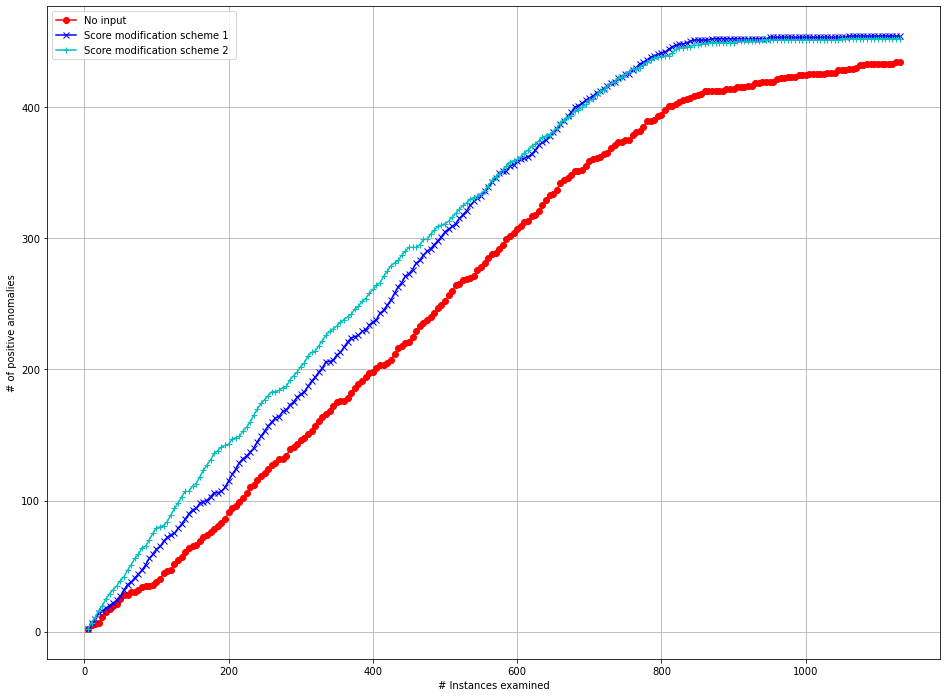

In [20]:
plt.figure(figsize=[16,12])
plt.grid()
plt.xlabel('# Instances examined')
plt.ylabel('# of positive anomalies')
max_x = max(np.max(num_revealed_1),np.max(num_revealed_2))
max_y = max(np.max(cum_correct_1),np.max(cum_correct_2))
area = max_x*max_y
_auc1 = auc(  num_revealed_1, cum_correct_1)/area
_auc2 = auc(  num_revealed_2, cum_correct_2)/area
_auc3 = auc(  num_revealed_3, cum_correct_3)/area
plt.plot(num_revealed_1, cum_correct_1,'r',label='No input',marker='o')
plt.plot(num_revealed_2, cum_correct_2,'b',label='Score modification scheme 1 ', marker='x')
plt.plot(num_revealed_3, cum_correct_3,'c',label='Score modification scheme 2 ', marker='+')
plt.legend()
plt.show()



22935